# Introduction
Please refer to my blog for detail mathematic and biological reasoning.

# Benchmark using simulated datasets generate by CME defined stochastic models 
- [dyngen generated simulations](https://zenodo.org/records/4637926) and [some of them downloaded](https://github.com/Spencerfar/LatentVelo/tree/main/synthetic_datasets) and their [example usage](https://github.com/Spencerfar/LatentVelo/tree/main/paper_notebooks)

## Quick check velocity and ground truth of simulated data generated by CME

In [1]:
import scvelo as scv
import scanpy as sc
import logging
import sys, re, random
import numpy as np
from datetime import datetime
from scipy import sparse

In [ ]:
b2b=sc.read('/data/wanglab_mgberis/Dyngen_datasets/latentVelo_github/bifurcation_2batches.h5ad')
b2b

In [ ]:
#just wanna see the false positive rate of scrublet
b2b_=sc.pp.scrublet(b2b, batch_key="batch",copy=True,n_prin_comps=25)
sum(b2b_.obs['predicted_doublet'])
del b2b_

In [ ]:
#below confirms the b2b.X is spliced
np.allclose((b2b.X - b2b.layers['counts_spliced']).data, 0)

## Wrangle AnnData object
We decide to:
- store raw data in a layer
- store spliced counts in both adata.X and adata.layers
- store unspliced counts in adata.layers

It is according to [here](https://github.com/theislab/scvelo/issues/525#issuecomment-891056397)
> The current workflow works with the spliced counts in adata.X and expects the layers 'unspliced' and 'spliced'. You can, of course, store the raw count matrix in adata.layers as well if you need it.
I quickly skimmed the scvelo code base and believe you could also store the raw data in adata.X without breaking anything - no guarantees on this, though, at this point. From what I saw, the only thing that would change is the neighbor graph (this will effect the imputation by moments), dimension reduction (i.e. PCA) and latent space embedding (e.g. UMAP) since these are calculated on adata.X. Did not investigate how this would look for/change the pancreas and dentate gyrus analysis/result.

and [scvelo stores unspliced and spliced counts (spliced both in adata.X and adata.layers)](https://github.com/scverse/scanpy/issues/1860#issuecomment-873990253)

In [ ]:
b2b.layers['spliced'] = b2b.layers['counts_spliced']
b2b.layers['unspliced'] =b2b.layers['counts_unspliced']

### check relation between traj_progression and milestone

In [5]:
b2b.uns['traj_progressions']['edge'] = (
    b2b.uns['traj_progressions']['from'] + '->' + b2b.uns['traj_progressions']['to']
)
b2b.uns['traj_progressions']['edge']

0       right_sBmid->right_sD
1          right_sA->right_sB
2       right_sD->right_sEndD
3          right_sA->right_sB
4         left_sD->left_sEndD
                ...          
4995    right_sB->right_sBmid
4996    right_sB->right_sBmid
4997         left_sA->left_sB
4998         left_sA->left_sB
4999    right_sBmid->right_sD
Name: edge, Length: 5000, dtype: object

In [6]:
b2b.uns['traj_progressions']['edge'].index = [
    f"cell{int(i) + 1}" for i in b2b.uns['traj_progressions']['edge'].index
]
b2b.uns['traj_progressions']['edge']

cell1       right_sBmid->right_sD
cell2          right_sA->right_sB
cell3       right_sD->right_sEndD
cell4          right_sA->right_sB
cell5         left_sD->left_sEndD
                    ...          
cell4996    right_sB->right_sBmid
cell4997    right_sB->right_sBmid
cell4998         left_sA->left_sB
cell4999         left_sA->left_sB
cell5000    right_sBmid->right_sD
Name: edge, Length: 5000, dtype: object

In [7]:
b2b.obs['edge']=b2b.uns['traj_progressions']['edge'].loc[b2b.obs['milestone'].index]
b2b.obs['edge']

cell2765       right_sA->right_sB
cell4768       right_sA->right_sB
cell3815         left_sA->left_sB
cell3500    right_sD->right_sEndD
cell2736       right_sA->right_sB
                    ...          
cell4373      left_sBmid->left_sC
cell3402      left_sC->left_sEndC
cell1240         left_sA->left_sB
cell438     right_sBmid->right_sD
cell416     right_sB->right_sBmid
Name: edge, Length: 2000, dtype: object

In [9]:
import pandas as pd
pd.crosstab(b2b.obs['milestone'], b2b.obs['edge']).T.to_csv(
    'milestone_edge_crosstab.csv', 
                       index=True,           # Include row index (edge)
                       header=True,          # Include column headers (milestone)
                       index_label='edge') 

In [10]:
b2b.write("/data/wanglab_mgberis/UT_scRNAseq/scvelo/bifurcation_2batches_for_scVelo.h5ad", compression='gzip')

## Default scVelo pipeline fails to capture ground truth velocity

In [11]:
adata = sc.read("/data/wanglab_mgberis/UT_scRNAseq/scvelo/bifurcation_2batches_for_scVelo.h5ad")
for key in ['moments', 'neighbors']:
    if key in adata.obsp or key in adata.uns:
        logging.info(f'found {key}')
        adata.obsp.pop(key, None)
        adata.uns.pop(key, None)
if 'fit_pars' in adata.varm:
    logging.info('found fit_pars')
    del adata.varm['fit_pars']

### plot ground truth

In [ ]:
sc.tl.umap(adata)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
scv.pl.umap(adata, color=['batch', 'milestone', 'sim_time'],
            frameon='artist', legend_loc='right', ncols=3, save='b2b_ground-truth.png')

### run scvelo default pipeline

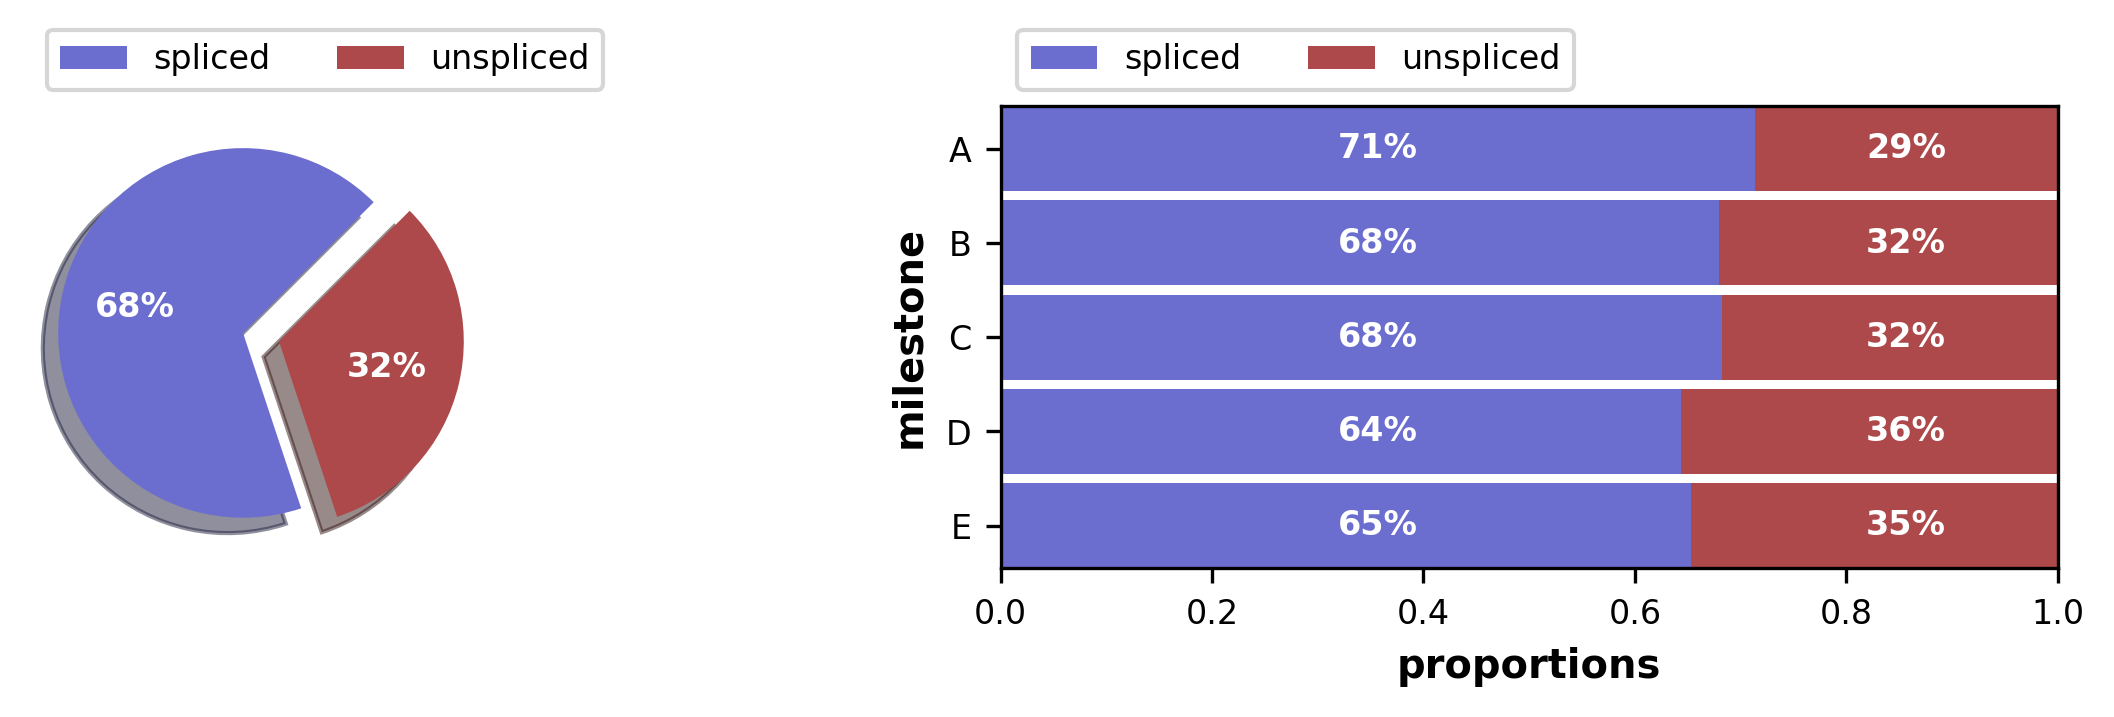

In [11]:
logging.info('1b.save proportion plot')
scv.pl.proportions(adata,groupby='milestone',dpi=300,show=True)

In [ ]:
logging.info('1c.Preprocessing,PCA,findNeighbour,Calculate Moments')
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

logging.info('1d.EM fitting and calculate scVelo dynamic RNA velocity')
scv.tl.recover_dynamics(adata,n_jobs=81)
scv.tl.velocity(adata, mode='dynamical')

logging.info('1e.calculate Markov chain of the differentiation process')
scv.tl.velocity_graph(adata)

In [ ]:
logging.info("2.velocity embeding(independent of root cells)")
# scv.pl.velocity_embedding(adata, basis='umap',color='sim_time', 
#                           arrow_length=1, arrow_size=2, dpi=300,show=False,
#                           frameon=True)
scv.pl.velocity_embedding_stream(adata, basis='umap',color='milestone',
                                 legend_loc='right margin',show=True,
                                 save='b2b_default_embedding.png')

logging.info('2a.infer root cell, and calculate gene-shared latent time corrected by neighborhood convolution')
scv.tl.latent_time(adata)# identical to recover_latent_time introduced in scVelo paper
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80,dpi=300, show=True,
               save='b2b_default_latent-time.png')

## Customized scVelo pipline
- Enfore similarity of input cells by reducing trajectory complexicity
- Use PCA embedding if it resolve the trajectory well
- Improve statistical robustness by leveraging velocity, PCA and/or neighbor information of larger population

### Setup modules,functions

In [ ]:
import scvelo as scv
import scanpy as sc
import logging
import sys, re, random
import numpy as np
from datetime import datetime
from scipy import sparse
import warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set up logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
log_filename = f"__{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    filename=log_filename,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def log_n_print(msg):
    logging.info(msg)
    print(msg)

### Define experiment parameters

In [ ]:
# =============================================================================
# CONFIGURATION PARAMETERS
# =============================================================================

# Task configuration: (h5ad filename prefix, whether to (re-)fit model, whether to save fitted output)
# Each tuple defines an analysis task with:
# - h5ad filename prefix: base name for input files (will look for {prefix}_for_scVelo.h5ad)
# - fit_bool: whether to rerun the full velocity fitting pipeline
# - save_bool: whether to save the fitted velocity model output
task_fit_save = [
    ['bifurcation_2batches', True, False]
]

# Column name in adata.obs that contains cell group/type annotations
# Used for subsetting cells and defining root populations
root_config=['milestone']

# Define cell population subsets for velocity analysis
# Each subset represents a group of cell types to analyze together
# Format: list of cell type identifiers that should exist in adata.obs[root_config[0]]
ss0_list = [
    ['A','B'],
    ['B','D'],
    ['A','C'],
    ['C','E'],
    ['A','B','D'],
    ['A','C','E'],
    ['A','B','C','D','E']
]

# The subset of elements of ss0_list. 
#  RNA velocity analysis on each subset will borrow info from its parant population
#  defined by the elements of ss0_list.
ss1_list=[[] for _ in ss0_list]

# Experimental configuration parameters for reproducibility and method comparison
# Each tuple contains: (random_seed, recompute_neighbors, recompute_PCA)
# - random_seed: ensures reproducible results across runs
# - recompute_neighbors: whether to recalculate neighborhood graph
# - recompute_PCA: whether to recalculate PCA embedding
seed_reNeibo_rePCA = [
    (1, False, False),
    # (2, True, False),
    # (3, True, True),
]

# Embedding methods to use for velocity projection
embed_basis=['pca','umap']

# Set scVelo verbosity level (0=silent, 1=errors, 2=warnings, 3=info, 4=debug)
scv.settings.verbosity = 3

### Define related funtions

In [ ]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================
# clear cache
def clear_velocity_graph(adata, verbose=True):
    """
    Remove cached velocity graph-related keys from .uns to force recomputation.
    
    Parameters:
        adata : AnnData
            The AnnData object (or subset) to clear.
        verbose : bool
            Whether to print which keys were removed.
    Returns:
        adata : AnnData
            The same AnnData object with velocity cache cleared
    """
    keys = ['velocity_graph', 'velocity_graph_neg', 'velocity_self_transitions']
    for key in keys:
        if key in adata.uns:
            del adata.uns[key]
            if verbose:
                print(f"Removed adata.uns['{key}']")
    return adata

def clean_velocity_legacy(adata_):
    """
    Removes legacy or conflicting velocity-related keys from AnnData object.
    """
    for key in ['moments', 'neighbors']:
        if key in adata_.obsp or key in adata_.uns:
            log_n_print(f'found {key}')
            adata_.obsp.pop(key, None)
            adata_.uns.pop(key, None)

    if 'fit_pars' in adata_.varm:
        log_n_print('found fit_pars')
        del adata_.varm['fit_pars']
    
    return adata_

def scvelo_pp(adata_,save_bool_,ss0_):
    """
    Preprocessing: filtering, normalization, PCA, neighbors, moments, dynamics.
    
    This function performs the core scVelo workflow:
    1. Gene filtering and normalization
    2. PCA and neighbor computation
    3. Moments calculation (spliced/unspliced RNA ratios)
    4. UMAP embedding
    5. Dynamical model fitting
    6. Velocity calculation
    
    Parameters:
        adata_ : AnnData
            Input single-cell data with spliced/unspliced counts
        save_bool_ : bool
            Whether to save the fitted model to disk
        ss0_ : list
            List of cell types being analyzed (used for filename)
    """
    log_n_print('1c.Preprocessing,PCA,findNeighbour,Calculate Moments')
    scv.pp.filter_and_normalize(adata_, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_, n_pcs=30, n_neighbors=30)                
    sc.tl.umap(adata_)
    log_n_print('1d.EM fitting and calculate scVelo dynamic RNA velocity')
    scv.tl.recover_dynamics(adata_, n_jobs=81)
    scv.tl.velocity(adata_, mode='dynamical')
    if save_bool_:
        log_n_print('1f.save scVelo result')
        adata_.write(f"{i}_{''.join(sorted(ss0_))}_scVelo_fitted.h5ad", compression='gzip')
    return adata_

def reNeibor_rePCA(adata2,reNeibor_bool,rePCA_bool):
    """
    Optionally rerun PCA and neighbors to reset the graph structure.
    
    Parameters:
        adata2 : AnnData
            Input data with existing PCA/neighbors
        reNeibor_bool : bool
            Whether to recompute neighborhood graph
        rePCA_bool : bool
            Whether to recompute PCA embedding
            
    Returns:
        adata2 : AnnData
            Data with updated PCA/neighbors if requested
    """    
    if reNeibor_bool:
        if rePCA_bool:
            del adata2.obsm['X_pca']
            logging.info('delete xpca')
            sc.pp.pca(adata2)
            logging.info('rerun sc.pp.pca')
        scv.pp.neighbors(adata2)
        logging.info('rerun pp.neighbors')
    return adata2

def evel_out_dir(ss0_,seed_,embed_basis_1,batch_2,reNeibor_bool_,rePCA_bool_):
    """
    Construct descriptive output directory name based on analysis parameters.

    Parameters:
        ss0_ : list
            Cell types in current analysis
        seed_ : int
            Random seed used
        embed_basis_1 : str
            Embedding method ('pca' or 'umap')
        batch_2 : str
            Batch identifier or 'all'
        reNeibor_bool_ : bool
            Whether neighbors were recomputed
        rePCA_bool_ : bool
            Whether PCA was recomputed
            
    Returns:
        figdir : str
            Formatted directory path for saving results
    """
    figdir = f'./res_scvelo_b2b_input{"".join(sorted(ss0_))}_seed{seed_}_embed{embed_basis_1}_{batch_2}'
    if reNeibor_bool_:
        figdir += '_reNeibor'
    if rePCA_bool_:
        figdir += '_rePCA'
    log_n_print(f"\n\n<================== initiated: {figdir} | ss0: {''.join(ss0_)}")
    return figdir

def scvelo_classic_steps(subset, adata_name, seed, out_dir,
                         root_config=['milestone', ['A']],
                         embed_basis='umap'):
    """
    Execute the complete scVelo visualization and analysis pipeline.
    
    This function performs the main velocity analysis workflow:
    1. Generate basic embedding plots
    2. Compute velocity graph
    3. Create velocity vector field visualizations
    4. Infer latent time (pseudotime) with and without root cells
    5. Generate comprehensive result plots
    
    Parameters:
        subset : AnnData
            Preprocessed single-cell data subset
        adata_name : str
            Base name for output files
        seed : int
            Random seed for reproducibility
        out_dir : str
            Directory for saving results
        root_config : list, default=['milestone', ['A']]
            [column_name, [root_cell_types]] for latent time inference
        embed_basis : str, default='umap'
            Embedding method for visualization ('pca' or 'umap')
    """
    # Set output directories for scanpy and scvelo
    sc.settings.figdir = out_dir
    scv.settings.figdir = out_dir
    
    # Create descriptive filename components
    celltypes = "".join(sorted(subset.obs[root_config[0]].unique().tolist()))
    i = adata_name
    
    # Select appropriate plotting function
    pl_func = {
        "umap": sc.pl.umap,
        "pca": sc.pl.pca
    }
    
    # =========================================================================
    # 1. BASIC EMBEDDING VISUALIZATION
    # =========================================================================
    log_n_print(f"1a. Generating {embed_basis} embedding plot")
    pl_func[embed_basis](
        subset,
        color=root_config[0],
        frameon=False,
        legend_loc='right margin',
        show=False,
        title=i,
        save=f"{i}_{celltypes}_{embed_basis}_seed{seed}.png",
    )

    # =========================================================================
    # 2. VELOCITY GRAPH COMPUTATION
    # =========================================================================
    velocity_error = None
    try:
        scv.tl.velocity_graph(subset)
        log_n_print("Velocity graph computed successfully")
    except Exception as e:
        velocity_error = e
        log_n_print("Error computing velocity graph:")
        log_n_print(str(e))
    
    # =========================================================================
    # 3. VELOCITY VISUALIZATIONS (only if graph computation succeeded)
    # =========================================================================
    if velocity_error is None:
        log_n_print('3a. Generating velocity embedding plot')
        
        # Clear any existing velocity embedding
        subset.obsm.pop('velocity_umap', None)
        
        # Compute velocity embedding
        scv.tl.velocity_embedding(subset, basis=embed_basis)
        
        # Plot velocity vectors on embedding
        scv.pl.velocity_embedding(
            subset,
            basis=embed_basis,
            color=root_config[0],
            arrow_length=1,
            arrow_size=3,
            dpi=300,
            frameon=False,
            show=False,
            save=f"{i}_{celltypes}_velocity_embedding_seed{seed}.pdf",
        )
        
        # =====================================================================
        # 3b. VELOCITY STREAM PLOT
        # =====================================================================
        log_n_print('3b. Generating velocity stream plot')
        try:
            scv.pl.velocity_embedding_stream(
                subset,
                basis=embed_basis,
                dpi=300,
                color=root_config[0],
                show=False,
                legend_loc='right margin',
                save=f"{i}_{celltypes}_velocity_embedding_stream_seed{seed}.png",
            )
        except Exception as e1:
            log_n_print("Error in velocity_embedding_stream (first attempt):")
            log_n_print(str(e1))
            
            # Try with recomputation
            try:
                log_n_print("Attempting stream plot with recomputation...")
                scv.pl.velocity_embedding_stream(
                    subset,
                    basis=embed_basis,
                    dpi=300,
                    recompute=True,
                    color=root_config[0],
                    show=False,
                    legend_loc='right margin',
                    save=f"{i}_{celltypes}_velocity_embedding_stream_recomputed_seed{seed}.png",
                )
            except Exception as e2:
                log_n_print("Error in velocity_embedding_stream (even after recomputation):")
                log_n_print(str(e2))
                log_n_print("Skipping stream plot for this subset")
        
        # =====================================================================
        # 4. LATENT TIME INFERENCE
        # =====================================================================
        
        # 4a. Latent time without root cell specification
        log_n_print('4a. Inferring latent time without root cell specification')
        
        # Clean any existing root cell annotations
        if 'root_cells' in subset.obs:
            del subset.obs['root_cells']
        
        # Compute latent time (pseudotime) based on velocity
        scv.tl.latent_time(subset)
        
        # Plot latent time without root
        scv.pl.scatter(
            subset,
            basis=embed_basis,
            color='latent_time',
            show=False,
            color_map='gnuplot',
            size=80,
            dpi=300,
            save=f"{i}_{celltypes}_latent_time_noRoot_seed{seed}.png",
        )
        
        # 4b. Latent time with root cell specification
        log_n_print('4b. Defining root cells and recomputing latent time')
        
        # Define root cells based on cell type annotation
        # Uses the first cell type in sorted order as root
        root_cells = subset.obs_names[subset.obs[root_config[0]].isin(root_config[1])]
        subset.obs['root_cells'] = subset.obs_names.isin(root_cells)
        
        log_n_print(f'Root cells defined as: {root_config[1]} ({len(root_cells)} cells)')
        
        # Recompute latent time with root cell constraint
        scv.tl.latent_time(subset, root_key='root_cells')
        
        # Plot latent time with root specification
        scv.pl.scatter(
            subset,
            basis=embed_basis,
            color='latent_time',
            color_map='gnuplot',
            size=80,
            dpi=300,
            show=False,
            save=f"{i}_{celltypes}_latent_time_AAsRoot_seed{seed}.png",
        )
        
        log_n_print(f'Completed velocity analysis for {celltypes}')

### Run scVelo on different size of cell populations

In [ ]:
# =============================================================================
# Configure logging
# =============================================================================

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

log_n_print("Starting scVelo RNA velocity analysis pipeline")
log_n_print(f"Analysis configuration:")
log_n_print(f"  - Tasks: {len(task_fit_save)}")
for idx, (task_name, fit_bool, save_bool) in enumerate(task_fit_save):
    log_n_print(f"    Task {idx+1}: '{task_name}' (fit={fit_bool}, save={save_bool})")

log_n_print(f"  - Cell type subsets: {len(ss0_list)}")
for idx, subset in enumerate(ss0_list):
    log_n_print(f"    Subset {idx+1}: {subset}")

log_n_print(f"  - Embedding methods: {embed_basis}")
for idx, method in enumerate(embed_basis):
    log_n_print(f"    Method {idx+1}: {method}")

log_n_print(f"  - Seeds/configurations: {len(seed_reNeibo_rePCA)}")
for idx, (seed, reNeibor, rePCA) in enumerate(seed_reNeibo_rePCA):
    log_n_print(f"    Config {idx+1}: seed={seed}, reNeibor={reNeibor}, rePCA={rePCA}")

# =============================================================================
# Iterate through all combinations of tasks and experimental configurations
# =============================================================================
from itertools import product
for (i, fit_bool, save_bool), (seed, reNeibor_bool, rePCA_bool) in product(task_fit_save, seed_reNeibo_rePCA):
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    
    log_n_print(f"{'='*60}")
    log_n_print(f"Starting new analysis iteration:")
    log_n_print(f"  - Task (h5ad prefix): {i}")
    log_n_print(f"  - Fit model: {fit_bool}")
    log_n_print(f"  - Save results: {save_bool}")
    log_n_print(f"  - Random seed: {seed}")
    log_n_print(f"  - Recompute neighbors: {reNeibor_bool}")
    log_n_print(f"  - Recompute PCA: {rePCA_bool}")
    
    # Clear any existing adata from previous iterations
    if 'adata' in locals():
        del adata
    
    # =========================================================================
    # DATA LOADING AND PREPROCESSING
    # =========================================================================
    
    if fit_bool:
        log_n_print('1. Loading input data')
        
        # Load the prepared h5ad file
        input_file = f"{i}_for_scVelo.h5ad"
        adata = sc.read_h5ad(input_file)
        log_n_print(f"Loaded data: {adata.shape[0]} cells × {adata.shape[1]} genes")
        
        # Clean legacy velocity-related data
        adata = clean_velocity_legacy(adata)
        
        # =====================================================================
        # BATCH-WISE ANALYSIS
        # =====================================================================
        
        # Analyze each batch separately, plus combined analysis
        batch_categories = list(adata.obs['batch'].cat.categories) + ['all']
        
        for batch_ in batch_categories:
            log_n_print(f"\n--- Processing batch: {batch_} ---")
            
            # Subset data by batch (or use all data)
            if batch_ == 'all':
                adata_batch = adata
                batch_label = 'all'
            else:
                adata_batch = adata[adata.obs['batch'] == batch_]
                batch_label = batch_.replace(' ', '')  # Remove spaces for filenames
            
            log_n_print(f"Batch subset: {adata_batch.shape[0]} cells")
            
            # =================================================================
            # CELL TYPE SUBSET ANALYSIS
            # =================================================================
            
            # Analyze each defined cell type combination
            for ss0, ss1 in zip(ss0_list, ss1_list):
                log_n_print(f"\n--- Processing cell types: {ss0} ---")
                
                # Subset to cells of specified types
                cell_mask = adata_batch.obs[root_config[0]].isin(ss0)
                adata1 = adata_batch[cell_mask]
                
                if adata1.shape[0] == 0:
                    log_n_print(f"No cells found for types {ss0} in batch {batch_}. Skipping.")
                    continue
                
                log_n_print(f"Cell subset: {adata1.shape[0]} cells")
                
                # Run scVelo preprocessing and velocity calculation
                adata1 = scvelo_pp(adata1, save_bool, ss0)
                
                # =============================================================
                # EMBEDDING METHOD ANALYSIS
                # =============================================================
                
                # Analyze with each embedding method
                for embed_basis_ in embed_basis:
                    log_n_print(f"\n--- Processing embedding: {embed_basis_} ---")
                    
                    # Generate output directory name
                    out_dir = eval_out_dir(ss0, seed, embed_basis_, batch_label, 
                                         reNeibor_bool, rePCA_bool)
                    
                    # Create output directory
                    import os
                    os.makedirs(out_dir, exist_ok=True)
                    
                    # Define root cells (first cell type in sorted order)
                    root_cells = [sorted(ss0)[0]]
                    
                    # Run complete velocity analysis pipeline
                    scvelo_classic_steps(
                        subset=adata1,
                        embed_basis=embed_basis_,
                        adata_name=i,
                        seed=seed,
                        out_dir=out_dir,
                        root_config=[root_config[0], root_cells]
                    )
                    
                    log_n_print(f"Completed analysis for {ss0} with {embed_basis_}")
                  
log_n_print("=" * 60)
log_n_print("scVelo RNA velocity analysis pipeline completed successfully!")
warnings.filterwarnings("default", category=DeprecationWarning)

### Run with npc=10 (original is 30)
- Conclusion: no help,sometimes worse

In [ ]:
def scvelo_pp(adata_,save_bool_,ss0_):
    """
    Modify the argument of n_pcs to be 10
    """
    log_n_print('1c.Preprocessing,PCA,findNeighbour,Calculate Moments')
    scv.pp.filter_and_normalize(adata_, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_, n_pcs=30, n_neighbors=30)                
    sc.tl.umap(adata_)
    log_n_print('1d.EM fitting and calculate scVelo dynamic RNA velocity')
    scv.tl.recover_dynamics(adata_, n_jobs=81)
    scv.tl.velocity(adata_, mode='dynamical')
    if save_bool_:
        log_n_print('1f.save scVelo result')
        adata_.write(f"{i}_{''.join(sorted(ss0_))}_scVelo_fitted.h5ad", compression='gzip')
    return adata_

# rerun the iteration through all combinations of tasks and experimental configurations

### Run with velocity etc generated from larger population
#### update arguments and function

In [ ]:
ss0_list = [
    ['A','B','D'],
    ['A','C','E'],
    ['A','B','C','D','E']
]

ss1_list=[
    [['A','B'],['B','D']],
    [['A','C'],['C','E']],
    [['A','B'],['B','D'],['A','C'],['C','E']]
]

seed_reNeibo_rePCA = [
    (1, False, False),
    (2, True, False),
    (3, True, True),
]

In [ ]:
"""
This is the modified core execution loop to enable subset analysisw that
borrows information from parent population.

It uses itertools.product() to create a Cartesian product of all configuration combinations.

Structure:
- Outer loop: task_fit_save × seed_reNeibo_rePCA combinations
- Inner loops: batches × cell_type_subsets × embedding_methods × hierarchical_subsets
"""

from itertools import product

# =============================================================================
# MAIN EXECUTION LOOP - CARTESIAN PRODUCT OF ALL CONFIGURATIONS
# =============================================================================

# Create all combinations of (task_parameters, experimental_parameters)
# product() generates: [(task1, config1), (task1, config2), (task2, config1), ...]
# Current example: [(['bifurcation_2batches', True, False], (1, False, False))]
for (i, fit_bool, save_bool), (seed, reNeibor_bool, rePCA_bool) in product(task_fit_save, seed_reNeibo_rePCA):
    
    # =========================================================================
    # REPRODUCIBILITY SETUP
    # =========================================================================
    
    # Set random seeds for reproducible results across libraries
    random.seed(seed)      # Python's random module
    np.random.seed(seed)   # NumPy random operations
    
    # =========================================================================
    # ITERATION STATUS LOGGING
    # =========================================================================
    
    log_n_print(f"---")  # Visual separator between iterations
    log_n_print(f"Task(h5ad label): {i}, Fit: {fit_bool}, Save: {save_bool}")
    log_n_print(f"Seed: {seed}, reNeibor_bool: {reNeibor_bool}, rePCA_bool: {rePCA_bool}")
    
    # =========================================================================
    # MEMORY MANAGEMENT
    # =========================================================================
    
    # Clean up any existing adata from previous iterations to prevent memory issues
    # locals() returns dictionary of local variables
    if 'adata' in locals():
        del adata
    
    # =========================================================================
    # CONDITIONAL EXECUTION - ONLY RUN IF FITTING IS ENABLED
    # =========================================================================
    
    # fit_bool allows skipping the full pipeline (useful for testing/visualization only)
    if fit_bool:
        log_n_print('1.input')
        
        # Load the main dataset file
        # Expected filename format: {task_name}_for_scVelo.h5ad
        adata = sc.read_h5ad(f"{i}_for_scVelo.h5ad")
        
        # Remove any legacy/conflicting velocity data from previous analyses
        adata = clean_velocity_legacy(adata)
        
        # =====================================================================
        # LEVEL 1: BATCH-WISE ANALYSIS
        # =====================================================================
        # Process each experimental batch separately, plus combined analysis
        
        # Get all unique batch categories + add 'all' for combined analysis
        # Example: ['batch1', 'batch2', 'all']
        batch_list = list(adata.obs['batch'].cat.categories) + ['all']
        
        for batch_ in batch_list:
            log_n_print(f"Processing batch: {batch_}")
            
            # Subset data by batch or use full dataset
            if batch_ == 'all':
                adata_batch = adata           # Use complete dataset
                batch_1 = 'all'             # Label for output files
            else:
                # Subset to specific batch
                adata_batch = adata[adata.obs['batch'] == batch_]
                batch_1 = batch_.replace(' ', '')  # Remove spaces for filename compatibility
            
            # =================================================================
            # LEVEL 2: CELL TYPE SUBSET ANALYSIS
            # =================================================================
            # Analyze different combinations of cell types/developmental stages
            
            # ss0_list: primary cell type combinations to analyze
            # ss1_list: hierarchical subsets (currently empty but structure exists)
            for ss0, ss1 in zip(ss0_list, ss1_list):
                log_n_print(f"Processing cell types: {ss0}")
                
                # Subset to cells of specified types
                # root_config[0] = column name containing cell type annotations
                cell_type_mask = adata_batch.obs[root_config[0]].isin(ss0)
                adata1 = adata_batch[cell_type_mask]
                
                # Skip if no cells found for this combination
                if adata1.shape[0] == 0:
                    log_n_print(f"No cells found for {ss0} in batch {batch_}. Skipping.")
                    continue
                
                # Run full scVelo preprocessing pipeline
                # - Gene filtering and normalization
                # - PCA, neighbors, moments calculation
                # - Velocity model fitting
                adata1 = scvelo_pp(adata1, save_bool, ss0)
                
                # =============================================================
                # LEVEL 3: EMBEDDING METHOD ANALYSIS
                # =============================================================
                # Test different dimensionality reduction methods
                
                for embed_basis_ in embed_basis:
                    log_n_print(f"Processing embedding: {embed_basis_}")
                    
                    # =========================================================
                    # PRIMARY ANALYSIS - Main cell type combination
                    # =========================================================
                    
                    # Run complete velocity analysis pipeline
                    scvelo_classic_steps(
                        subset=adata1,
                        embed_basis=embed_basis_,
                        adata_name=i,
                        seed=seed,
                        # Generate output directory based on all parameters
                        out_dir=evel_out_dir(ss0, seed, embed_basis_, batch_1, reNeibor_bool, rePCA_bool),
                        # Use first cell type (alphabetically) as root
                        root_config=[root_config[0], [sorted(ss0)[0]]]
                    )
                    
                    # =========================================================
                    # HIERARCHICAL ANALYSIS - Subset analysis within main set
                    # =========================================================
                    # This allows borrowing information from parent population
                    # while focusing analysis on specific sub-populations
                    
                    for ss1_ in ss1:
                        log_n_print(f"Processing hierarchical subset: {ss1_}")
                        
                        # NOTE: ss1 is currently empty list, so this loop doesn't execute
                        # But structure exists for future hierarchical analyses
                        
                        # Debug breakpoint (commented out)
                        # import pdb; pdb.set_trace()
                        
                        # Create subset for hierarchical analysis
                        hierarchical_mask = adata1.obs[root_config[0]].isin(ss1_)
                        adata2 = adata1[hierarchical_mask]
                        
                        # Clear velocity graph cache to force fresh computation
                        adata2 = clear_velocity_graph(adata2)
                        
                        # Optionally recompute PCA/neighbors with different parameters
                        adata2_processed = reNeibor_rePCA(
                            adata2=adata2,
                            reNeibor_bool=reNeibor_bool,
                            rePCA_bool=rePCA_bool
                        )
                        
                        # Run velocity analysis on hierarchical subset
                        scvelo_classic_steps(
                            subset=adata2_processed,
                            embed_basis=embed_basis_,
                            adata_name=i,
                            seed=seed,
                            # Same output directory as parent analysis
                            out_dir=evel_out_dir(ss0, seed, embed_basis_, batch_1, reNeibor_bool, rePCA_bool),
                            # Use first cell type in subset as root
                            root_config=[root_config[0], [sorted(ss1_)[0]]]
                        )

# =============================================================================
# CLEANUP AND FINALIZATION
# =============================================================================

# Reset random seeds to non-deterministic state after analysis
random.seed()
np.random.seed()  
# Restore default warning behavior
# During analysis, warnings might have been suppressed or modified
warnings.filterwarnings("default", category=DeprecationWarning)

log_n_print("All analysis iterations completed successfully!")

#### Summerize: dir tree

In [ ]:
from pathlib import Path
from collections import defaultdict

# Set your root directory
root = Path("/data/wanglab_mgberis/UT_scRNAseq/res_scvelo_b2b_use-parent-velocity_subset-reNeibr-rePCA_umap-vs-pca_batch-specific_some-help")
pattern = "*velocity_embedding_stream*"
output_file = "velocity_embedding_stream_tree.md"

# Step 1: Collect matching files
matched_files = [f for f in root.rglob(pattern) if f.is_file()]

# Step 2: Organize into folder tree
tree = defaultdict(list)
for f in matched_files:
    rel_dir = f.parent.relative_to(root)
    tree[str(rel_dir)].append(f.name)

# Step 3: Format markdown output
lines = []
lines.append(f"### 📁 `{root}/`\n")

for folder in sorted(tree):
    lines.append(f"#### 📂 `{folder}/`")
    for fname in sorted(tree[folder]):
        if fname.startswith("0"):
            lines.append(f"**├── {fname}**")  # Bold highlight
        else:
            lines.append(f"├── {fname}")
        lines.append("\n")  # Empty line for spacing
    lines.append("\n")  # Empty line for spacing

# Step 4: Write to .md file
with open(output_file, "w") as f:
    f.write("\n".join(lines))

print(f"Tree saved to: {output_file}")

#### Summerize: data.frame and md

In [ ]:
from pathlib import Path
from collections import defaultdict
import re
import pandas as pd
import numpy as np

root = Path("/data/wanglab_mgberis/UT_scRNAseq/res_scvelo_b2b_use-parent-velocity_subset-reNeibr-rePCA_umap-vs-pca_batch-specific_some-help")
pattern = "*velocity_embedding_stream*"
output_file = "velocity_embedding_stream_summary.md"

# Step 1: Find files excluding .ipynb_checkpoints
matched_files = [
    f for f in root.rglob(pattern)
    if f.is_file() and ".ipynb_checkpoints" not in f.parts
]

# Step 2: Group files by relative folder
tree = defaultdict(list)
for f in matched_files:
    rel_dir = f.parent.relative_to(root)
    tree[str(rel_dir)].append(f.name)

# Step 3: Simplify filenames by removing common prefixes/suffixes
def simplify_filename(filename):
    s = re.sub(r"^0?scvelo_bifurcation_2batches_", "", filename)
    s = re.sub(r"_velocity_embedding_stream_seed\d+\.png$", "", s)
    return s

# Step 4: Define expected categories
expected = {"ABCDE", "AB", "AC", "BD", "CE"}

# Step 5: Collect summary marks per folder
results = {}

for folder in sorted(tree):
    present_cleaned = set(simplify_filename(fn) for fn in tree[folder])
    checked = set(simplify_filename(fn) for fn in tree[folder] if fn.startswith("0"))
    folder_results = {}
    # print(checked)
    for name in sorted(expected):
        if name in present_cleaned:
            # import pdb; pdb.set_trace()
            mark = 1 if name in checked else 0
        else:
            mark = np.nan
        folder_results[name] = mark
    # print(folder_results)    
    results[folder] = folder_results

# Step 6: Generate data.frame and markdown table
# Prepare table components
categories = sorted(expected)
header = "| Folder | " + " | ".join(categories) + " |"
separator = "|--------" + "|--------" * len(categories) + "|"

# Markdown lines
lines = []
lines.append("# Velocity Embedding Stream Summary")
lines.append(f"Root folder: `{root}`\n")
lines.append(header)
lines.append(separator)

# DataFrame content
df_rows = []

for folder, folder_results in results.items():
    # Markdown row
    row_md = [folder]
    # DataFrame row
    row_df = {"Folder": folder}

    for cat in categories:
        val = folder_results[cat]
        if np.isnan(val):
            mark = "NA"
            num = np.nan
        elif val == 1:
            mark = "✓"
            num = int(1)
        else:
            mark = "✗"
            num = int(0)

        row_md.append(mark)
        row_df[cat] = num

    lines.append("| " + " | ".join(row_md) + " |")
    df_rows.append(row_df)

# Save Markdown file
with open(output_file, "w") as f:
    f.write("\n".join(lines))

print(f"Markdown summary saved to {output_file}")

# Create and return the DataFrame
df_result = pd.DataFrame(df_rows)
df_result.set_index("Folder", inplace=True)
# df_result

In [ ]:
import re

# Reset index so Folder becomes a column
df_result = df_result.reset_index()

# Extract metadata from the "Folder" column
df_result["Seed"] = df_result["Folder"].str.extract(r"seed(\d+)")[0].astype(int)
df_result["Input"] = df_result["Folder"].str.extract(r"_input([A-Z]+)_")[0].astype(str)

df_result["Embedding"] = df_result["Folder"].apply(
    lambda x: "pca" if "embedpca" in x else "umap" if "embedumap" in x else "unknown"
)

df_result["Batch"] = df_result["Folder"].apply(
    lambda x: "batch0" if "batch0" in x
    else "batch1" if "batch1" in x
    else "all" if "all" in x
    else "unknown"
)
df_result

In [ ]:
# Move Folder back as index
df_result = df_result.set_index("Folder")
df_result.to_csv("velocity_embedding_stream_summary.csv", index=True)

# scVelo on real world scRNAseq data: tumor developlment

## Seuratobj to anndata

refer to `/data/wanglab_mgberis/UT_scRNAseq/_scripts/seurat_scRNAseq5_convert2h5ad.R`

## Integration or not?
We decide not to integrate different batches of data based on the mathematics defining the scVelo dynamic model and its inference. Refer to my blog for reasoning.

## Read mtx from star-velocyto into adata
adata_from_starsolo_mtx() import: 
- 'Gene/'+path_mtx + 'matrix.mtx' to adata.X
- 'Velocyto/'+path_mtx+'spliced.mtx' to adata.layers['spliced']
- 'Velocyto/'+path_mtx+'unspliced.mtx' to adata.layers['unspliced']
- 'Velocyto/'+path_mtx+'ambiguous.mtx' to adata.layers['ambiguous']

In [ ]:
import os
import re
def get_path(start_directory,search_patterns = [r"genes\.tsv", r"features\.tsv"],verbose=False):
    regex = re.compile("|".join(search_patterns))
    found_path = []

    for root, _, files in os.walk(start_directory):
        if verbose:
            print(f"Searching in directory: {root}")
        for file in files:
            if verbose:
                print(f"  Checking file: {file}")
            if regex.search(file):
                a_path = os.path.join(root, file)
                if verbose: 
                    print(f"    Found a match: {a_path}")
                found_path.append(a_path)

    print(f"Found: {found_path}")
    return found_path

import gzip
import shutil
def gzip(filepath):
    gz_path = filepath + '.gz'
    with open(filepath, 'rb') as f_in, gzip.open(gz_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    print(f"Gzipped: {filepath} → {gz_path}")
    return gz_path

In [ ]:
import os
def ensure_file_format(filepath):
    """Check if gzipped mtx exists, if yes ensure companioin feature.tsv.gz exist; If not, ensure comapnion genes.tsv exist."""
    
    #1. get the path
    mtx_path = get_path(filepath,[r"matrix\.mtx"])
    features_path = get_path(filepath,[r"genes\.tsv", r"features\.tsv"])
    
    assert len(mtx_path) == 1 and len(features_path) == 1, "only one file expected!"
    mtx_path=mtx_path[0]
    features_path=features_path[0]
    
    #2. wrangle files to be compatible with scanpy
    if mtx_path.endswith('.gz'):
        assert 'features' in os.path.basename(features_path), "newer version has mtx.gz and features file"
        print(f"File already gzipped: {mtx_path}, and features.tsv exist")
        if not features_path.endswith('.gz'):
            gzip(features_path)        
        
    elif not 'genes' in os.path.basename(features_path[0]):
        #preivous version has mtx unzipped and genes file
        genes_path = re.sub(r"features", "genes", features_path)
        os.rename(features_path, genes_path)
        print(f"Renamed {features_path} into {genes_path}")

In [ ]:
import scvelo as scv
import scanpy as sc
import sys
import numpy as np
from scipy import sparse


def adata_from_starsolo_mtx(path_Solo_out='/data/wanglab_mgberis/UT_scRNAseq/starsolo_result/UT_ctrl/Solo.out/',
                            path_mtx='filtered/'):
    path=path_Solo_out
    ensure_file_format(path+'Gene/'+path_mtx)
    
    adata = sc.read_10x_mtx(path+'Gene/'+path_mtx)

    spliced=np.loadtxt(path+'Velocyto/'+path_mtx+'spliced.mtx', skiprows=3, delimiter=' ')
    shape = np.loadtxt(path+'Velocyto/'+path_mtx+'spliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)

    adata.layers['spliced']=sparse.csr_matrix((spliced[:,2], (spliced[:,0]-1, spliced[:,1]-1)), shape = (shape)).tocsr().T

    unspliced=np.loadtxt(path+'Velocyto/'+path_mtx+'unspliced.mtx', skiprows=3, delimiter=' ')
    adata.layers['unspliced']=sparse.csr_matrix((unspliced[:,2], (unspliced[:,0]-1, unspliced[:,1]-1)), shape = (shape)).tocsr().T

    ambiguous= np.loadtxt(path+'Velocyto/'+path_mtx+'ambiguous.mtx', skiprows=3, delimiter=' ')
    adata.layers['ambiguous']=sparse.csr_matrix((ambiguous[:,2], (ambiguous[:,0]-1, ambiguous[:,1]-1)), shape = (shape)).tocsr().T
    
    return adata.copy()

## Generate adata of all samples for scVelo
- store spliced and unspliced counts from star using adata_from_starsolo_mtx()
- keep count data of seurat in layer `X_fromSeurat`
- keep metadata of seurat

In [ ]:
import os
import re
import scanpy as sc

for i, j in [
    ['CTR', 'UT_ctrl'],
    ['STU', 'UT_s'],
    ['BTU', 'UT_b']
]:
    print(f"h5ad label: {i}, starsolo label: {j}")
    
    output_file = f"{i}_for_scVelo.h5ad"
    if os.path.exists(output_file):
        print(f"{output_file} exists, skipping.")
        continue

    adata1 = sc.read_h5ad(f"{i}_RNA.h5ad")
    adata = adata_from_starsolo_mtx(f"/data/wanglab_mgberis/UT_scRNAseq/starsolo_result/{j}/Solo.out/")
    adata.layers["raw_counts"] = adata.X.copy()
    adata.X = adata.layers["spliced"].copy()

    for k in list(adata1.layers.keys()):
        print(f"shape of {k} is {adata1.layers[k].shape}")
    print(f"shape of X is {adata1.X.shape}")

    for k in list(adata.layers.keys()):
        print(f"shape of {k} is {adata.layers[k].shape}")
    print(f"shape of X is {adata.X.shape}")

    cell1 = [re.sub(r'_.*', '', x) for x in adata1.obs.index.tolist()]
    gene1 = adata1.var.index.tolist()
    cell_intersect = list(set(cell1) & set(adata.obs.index.tolist()))
    gene_intersect = list(set(gene1) & set(adata.var.index.tolist()))

    adata_sub = adata[cell_intersect, gene_intersect].copy()
    for k in list(adata_sub.layers.keys()):
        print(f"shape of {k} is {adata_sub.layers[k].shape}")
    print(f"shape of X is {adata_sub.X.shape}")

    adata1_sub = adata1[adata1.obs[adata1.obs['cell_name'].isin(cell_intersect)].index.tolist(),
                        gene_intersect].copy()
    for k in list(adata1_sub.layers.keys()):
        print(f"shape of {k} is {adata1_sub.layers[k].shape}")
    print(f"shape of X is {adata1_sub.X.shape}")

    for k in list(adata_sub.layers.keys()):
        adata1_sub.layers[k] = adata_sub.layers[k]
        print(f"adata1_sub layer {k} has been replaced by adata_sub.layers {k}")
    adata1_sub.layers['X_fromSeurat'] = adata1_sub.X
    adata1_sub.X = adata_sub.X
    print("adata1_sub X has been replaced by adata_sub X")

    # fix '_index' column name in raw.var if present
    adata1_sub.raw.var.rename(columns={'_index': 'index'}, inplace=True)
    adata1_sub.write(f"{i}_for_scVelo.h5ad")

## Run scVelo on tumor cells only
### Setup modules,functions
same as for simulatd data

### Define experimental parameters

In [ ]:
task_fit_save = [
    ['CTR',True,False],
    ['STU',True,False],
    ['BTU',True,False],
    ['HPV',True,False]
]

seed_reNeibo_rePCA = [
    (1, False, False),
]

root_config=['celltype.v2']
root_index_in_ss0=1
root_index_in_ss1=1

ss0_list = [
    ['tumor_1','tumor_Ki67+'],
    ['tumor_1','tumor_Ki67+','tumor_2'],
    ['tumor_1','tumor_Ki67+','tumor_2','Epc','M','F'],
]

ss1_list = [
    [],
    [['tumor_1','tumor_Ki67+']],
    [['tumor_1','tumor_Ki67+']],
]

embed_basis=['pca','umap']


# =========================================================================
# Test the effect of redo dimension reduction for main set
re_dimRed_bool_list=[True,False]
# =========================================================================

#if wanna seperate batches
adata.obs['batch'] =  adata.obs['orig.ident']
adata.obs['batch'] = adata.obs['batch'].astype('category')

### Define related funtions
same as for simulatd data

### Iterate

In [ ]:
# =============================================================================
# Configure logging
# =============================================================================

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

log_n_print("Starting scVelo RNA velocity analysis pipeline")
log_n_print(f"Analysis configuration:")
log_n_print(f"  - Tasks: {len(task_fit_save)}")
for idx, (task_name, fit_bool, save_bool) in enumerate(task_fit_save):
    log_n_print(f"    Task {idx+1}: '{task_name}' (fit={fit_bool}, save={save_bool})")

log_n_print(f"  - Cell type subsets: {len(ss0_list)}")
for idx, subset in enumerate(ss0_list):
    log_n_print(f"    Subset {idx+1}: {subset}")

log_n_print(f"  - Embedding methods: {embed_basis}")
for idx, method in enumerate(embed_basis):
    log_n_print(f"    Method {idx+1}: {method}")

log_n_print(f"  - Seeds/configurations: {len(seed_reNeibo_rePCA)}")
for idx, (seed, reNeibor, rePCA) in enumerate(seed_reNeibo_rePCA):
    log_n_print(f"    Config {idx+1}: seed={seed}, reNeibor={reNeibor}, rePCA={rePCA}")

# =============================================================================
# Iterate through all combinations of tasks and experimental configurations
# same as for simulated data except here also test the effect of redo dimension reduction for main set
# =============================================================================

for (i, fit_bool, save_bool), (seed, reNeibor_bool, rePCA_bool) in product(task_fit_save, seed_reNeibo_rePCA):
    
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    
    # Log current processing parameters
    log_n_print(f"---")
    log_n_print(f"Task(h5ad label): {i}, Fit: {fit_bool}, Save: {save_bool}")
    log_n_print(f"Seed: {seed}, reNeibor_bool: {reNeibor_bool}, rePCA_bool: {rePCA_bool}")
    
    # Clean up previous adata object to save memory
    if 'adata' in locals():
        del adata
    
    # 1. Load input data
    log_n_print('1.input')
    adata = sc.read_h5ad(f"{i}_for_scVelo.h5ad")  # Load pre-processed velocity data
    adata = clean_velocity_legacy(adata)           # Clean legacy velocity annotations
    
    # 2. Handle batch processing
    # Process each batch separately plus all batches combined
    if 'batch' in adata.obs:
        batch_list = list(adata.obs['batch'].cat.categories) + ['all']
    else:
        batch_list = ['all']
    
    # Process each batch
    for batch_ in batch_list:
        if batch_ == 'all':
            adata_batch = adata
            batch_1 = 'all'
        else:
            adata_batch = adata[adata.obs['batch'] == batch_]
            batch_1 = batch_.replace(' ', '')  # Remove spaces for file naming
        
        # 3. Process cell type subsets
        for ss0, ss1 in zip(ss0_list, ss1_list):
            
            # Filter for specified cell types in ss0
            adata1 = adata_batch[adata_batch.obs[root_config[0]].isin(ss0)]
            
            # Test with and without redoing dimensionality reduction
            for re_dimRed_bool in re_dimRed_bool_list:
                adata2 = adata1.copy()
                
                # Optionally redo dimensionality reduction
                if re_dimRed_bool:
                    log_n_print(f"<---redo dimension reduction--->")
                    sc.tl.pca(adata2)        # Principal component analysis
                    sc.pp.neighbors(adata2)   # Compute neighborhood graph
                    sc.tl.umap(adata2)       # UMAP embedding
                
                # Apply scVelo preprocessing
                adata2 = scvelo_pp(adata2, save_bool, ss0)
                
                # 4. Process different embedding bases (PCA and UMAP)
                for embed_basis_ in embed_basis:
                    
                    # Generate output directory name
                    out_dir_ = eval_out_dir(i, ss0, seed, embed_basis_, batch_1, reNeibor_bool, rePCA_bool)
                    
                    # Run main scVelo analysis pipeline
                    scvelo_classic_steps(
                        subset=adata2,
                        embed_basis=embed_basis_,
                        adata_name=i,
                        seed=seed,
                        out_dir=out_dir_,
                        root_config=[root_config[0], [sorted(ss0)[root_index_in_ss0]]],
                        re_dimRed_bool=re_dimRed_bool
                    )
                    
                    # 5. Process secondary subsets (ss1) if they exist
                    # This allows borrowing information from parent population
                    # while focusing analysis on specific sub-populations
                    for ss1_ in ss1:
                        # Filter for ss1 cell types and clear velocity graph
                        adata3 = clear_velocity_graph(adata2[adata2.obs[root_config[0]].isin(ss1_)])
                        
                        # Run scVelo analysis on subset with optional reprocessing
                        scvelo_classic_steps(
                            subset=reNeibor_rePCA(adata2=adata3, reNeibor_bool=reNeibor_bool, rePCA_bool=rePCA_bool),
                            embed_basis=embed_basis_,
                            adata_name=i,
                            seed=seed,
                            out_dir=out_dir_,
                            root_config=[root_config[0], [sorted(ss1_)[root_index_in_ss1]]],
                            re_dimRed_bool=re_dimRed_bool
                        )

random.seed()
np.random.seed()
warnings.filterwarnings("default", category=DeprecationWarning)

## visulization adjustment
Potential strategies:
1. whether to order based on latent time 
2. adjust density of streams

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
scv.pl.scatter(
    adata2,
    basis='umap',
    color='latent_time',
    show=True,
    color_map='gnuplot',
    size=80,
    dpi=300,
    save=False,
    # alpha=0.3
    sort_order=False
)

In [ ]:
 scv.pl.velocity_embedding_stream(subset, basis='umap',dpi=300,size=170,density=3,
                                         color='celltype.v2',show=True,
                                         legend_loc='right margin', 
                                         # save=f"{i}_velocity_embedding_stream_connectedTumorCluster_seed{seed}.png"
                                        )

## Heatmap based on latent time using biological meaningful genes

### default heatmap is pretty but difficult to interpret

In [ ]:
top_genes = adata2.var['fit_likelihood'].sort_values(ascending=False).index[:200]
scv.pl.heatmap(adata2, var_names=top_genes, sortby='latent_time', col_color='celltype.v2', colorbar=True,
               n_convolve=100,
               # yticklabels=True,
               row_cluster=False,
               layer='X_fromSeurat'
              )

In [ ]:
scv.pl.heatmap(adata2, var_names=top_genes, sortby='latent_time', col_color='celltype.v2', colorbar=True,
               n_convolve=100,
               yticklabels=False,
               row_cluster=False,
               layer='X_fromSeurat'
              )

In [ ]:
scv.pl.heatmap(adata2, var_names=top_genes, sortby='latent_time', col_color='celltype.v2', colorbar=True,
               n_convolve=100,
               # yticklabels=True,
               row_cluster=False,
               # layer='X_fromSeurat'
              )

In [ ]:
scv.pl.heatmap(adata2, var_names=top_genes, sortby='latent_time', col_color='celltype.v2', 
               colorbar=True,cbar_pos=(0.02, 0.8, 0.05, 0.18),
               n_convolve=100,
               # yticklabels=True,
               row_cluster=False,
               layer='velocity'
              )

### Below suggests feasibility to draw heatmap using biological meaningful genes
- probably get the genes correlate with latent time most

In [ ]:
# top_genes = adata2.var['fit_likelihood'].sort_values(ascending=False).index[:200]
scv.pl.heatmap(adata2, var_names=['Mki67'], sortby='latent_time', col_color='celltype.v2', colorbar=True,
               n_convolve=100,
               yticklabels=True,
               row_cluster=False,
               layer='X_fromSeurat'
              )

In [ ]:
adata2

In [ ]:
if 'Mki67' in adata2.var_names:
    sc.pl.umap(adata2,color= ['Mki67'],use_raw=False,layer='X_fromSeurat')

### customized L_scv_pl_heatmap() to restore color bar and group legend,to label selected genes

In [ ]:
import scvelo_funs_jliu678edits
import importlib
importlib.reload(scvelo_funs_jliu678edits)

scvelo_funs_jliu678edits.L_scv_pl_heatmap(
    adata2, 
    var_names=top_genes[:50], 
    sortby='latent_time', 
    col_color='celltype.v2', 
    colorbar=True,
    n_convolve=100,
    yticklabels=True,
    row_cluster=False,
    # layer='X_fromSeurat'
    show=True
    )

### find genes correlated with latent time

In [ ]:
import importlib
import scvelo_funs_jliu678edits
importlib.reload(scvelo_funs_jliu678edits)
# from scvelo_funs_jliu678edits import L_rank_genes_by_latent_time

In [ ]:
cor_df = scvelo_funs_jliu678edits.L_rank_genes_by_latent_time(
    adata2, layer="X_fromSeurat", key="latent_time", method="spearman", adjust_method="fdr_bh"
)
print(cor_df)
cor_df[cor_df["gene"].isin(['Mki67'])]

In [ ]:
cor_df[(cor_df["correlation"].notna())]

In [ ]:
import importlib
importlib.reload(scvelo_funs_jliu678edits)
scvelo_funs_jliu678edits.L_volcanoPlot_gene_latent_time_cor(
    cor_df[(cor_df["correlation"].notna())],
    pval_key="pval",
    r_thresh=0.27,
    p_thresh=1e-50,
    figsize=(8, 6),
    title="Volcano Plot of Gene–Time Correlation",
    annotate_top=10,
)

In [ ]:
import pandas as pd
top_n = 100  # adjust as needed

# Top by absolute correlation (|correlation| descending)
top_corr = cor_df.loc[cor_df["correlation"].notna()].copy()
# top_corr.to_excel("all_genes.xlsx", index=True)

top_corr_neg = top_corr.sort_values("correlation", ascending=True).head(top_n)
top_corr_pos = top_corr.sort_values("correlation", ascending=False).head(int(top_n/2))
top_corr_pos = top_corr_pos.sort_values("correlation", ascending=True)

# Top by lowest p-value
# pval_key = "pval"
# top_pval = cor_df.sort_values(pval_key).head(top_n)

best_genes = pd.concat([top_corr_pos, top_corr_neg], axis=0)
best_genes = best_genes[best_genes['pval']<0.01]
# pd.set_option('display.max_rows', 100)# ineffective somehow
# best_genes.to_excel("gene_to_heatmap.xlsx", index=True)
best_genes

In [ ]:
# top_n = 200  # adjust as needed
# # Top by absolute correlation (|correlation| descending)
# top_corr = cor_df.loc[cor_df["correlation"].notna()].copy()
# top_corr["abs_corr"] = top_corr["correlation"].abs()
# top_corr = top_corr.sort_values("abs_corr", ascending=False).head(top_n)
# # print(top_corr)
# # Top by lowest p-value
# pval_key = "pval"
# top_pval = cor_df.sort_values(pval_key).head(top_n)
# # print(top_pval)

# # Merge to find overlapping genes
# best_genes = pd.merge(top_corr, top_pval, on="gene")
# best_genes['gene']

In [ ]:
import importlib
importlib.reload(scvelo_funs_jliu678edits)

scvelo_funs_jliu678edits.L_scv_pl_heatmap(
    adata2, 
    var_names=best_genes['gene'], 
    sortby='latent_time', 
    col_color='celltype.v2', 
    colorbar=True,
    n_convolve=100,
    yticklabels=False,
    row_cluster=False,
    layer='X_fromSeurat',
    # label_genes=None,
    label_genes=['Mki67','Cenpe','Birc5','Prc1','Vim'],
    show=True,
    min_label_spacing=0.05,
    x_outside = 1.02,
    print_actual_gene_order = True
    )

#### download xlsx, add biological interpretation, reload into memory

In [ ]:
STU_goi = pd.read_excel("STU_latent_time_heatmap_all_genes.xlsx", sheet_name=None)

In [ ]:
goi_neg=STU_goi['stem_gene_neg_correlated'].loc[STU_goi['stem_gene_neg_correlated']['keep'] == 1, "Gene(s)"].tolist()

In [ ]:
goi_pos=STU_goi['tumor_gene_pos_correlated'].loc[STU_goi['tumor_gene_pos_correlated']['keep'] == 1, "Gene(s)"].tolist()

In [ ]:
import importlib
importlib.reload(scvelo_funs_jliu678edits)
scvelo_funs_jliu678edits.L_scv_pl_heatmap(
    adata2, 
    var_names=best_genes['gene'], 
    sortby='latent_time', 
    col_color='celltype.v2', 
    colorbar=True,
    n_convolve=100,
    yticklabels=False,
    row_cluster=False,
    layer='X_fromSeurat',
    # label_genes=None,
    label_genes=[g for g in goi_neg + goi_pos if g not in ['Cxcl12','Lamp1','Sfrp2','Mgp']],
    show=True,
    min_label_spacing=0.03,
    x_outside = 1.02,
    print_actual_gene_order = False,
    figsize=(4,5),
    save='0STU_latent_time_heatmap.png'
    )